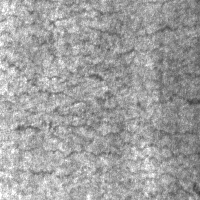

In [ ]:
from PIL import Image

filepath_crazing = 'NEU-DET/train/images/crazing/crazing_1.jpg'
Image.open(filepath_crazing)

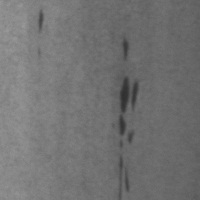

In [ ]:
filepath_inclusion = 'NEU-DET/train/images/inclusion/inclusion_1.jpg'
Image.open(filepath_inclusion)

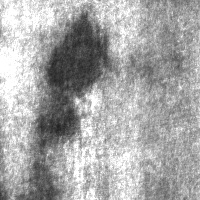

In [ ]:
filepath_patches = 'NEU-DET/train/images/patches/patches_1.jpg'
Image.open(filepath_patches)

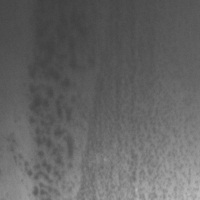

In [ ]:
filepath_ps = 'NEU-DET/train/images/pitted_surface/pitted_surface_1.jpg'
Image.open(filepath_ps)

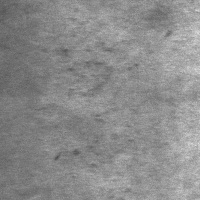

In [ ]:
filepath_ris = 'NEU-DET/train/images/rolled-in_scale/rolled-in_scale_1.jpg'
Image.open(filepath_ris)

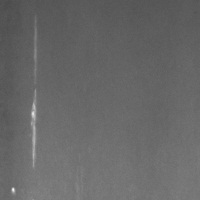

In [ ]:
filepath_scratch = 'NEU-DET/train/images/scratches/scratches_1.jpg'
Image.open(filepath_scratch)

# Problem 1: prepare the dataset

Implement `Dataset` and `DataLoader` objects for the training and validation sets for use with `pytorch-lightning` in Problem 2.

In [6]:
#Problem 1
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import tqdm
import numpy as np
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize(200),  # Resize the image to 200x200 pixels
    transforms.ToTensor()    # Convert the image to a PyTorch tensor
])

dataset_train = datasets.ImageFolder('/content/NEU-DET/train/images', transform=transform)
print(f'Number of images (all classes): {len(dataset_train)}')

dataloader_train = DataLoader(dataset_train, batch_size=25, shuffle=True)
for batch in dataloader_train:
    print(batch)
    break

dataset_val = datasets.ImageFolder('/content/NEU-DET/validation/images', transform=transform)
print(f'Number of images (all classes): {len(dataset_val)}')

dataloader_val = DataLoader(dataset_val, batch_size=25, shuffle=True)
for batch in dataloader_val:
    print(batch)
    break

Number of images (all classes): 1440
[tensor([[[[0.2549, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3451],
          [0.2510, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3412],
          [0.2510, 0.2549, 0.2588,  ..., 0.3333, 0.3333, 0.3333],
          ...,
          [0.5333, 0.5412, 0.5216,  ..., 0.6157, 0.6392, 0.6667],
          [0.5490, 0.5490, 0.5176,  ..., 0.6118, 0.6392, 0.6784],
          [0.5608, 0.5647, 0.5294,  ..., 0.6510, 0.6588, 0.6706]],

         [[0.2549, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3451],
          [0.2510, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3412],
          [0.2510, 0.2549, 0.2588,  ..., 0.3333, 0.3333, 0.3333],
          ...,
          [0.5333, 0.5412, 0.5216,  ..., 0.6157, 0.6392, 0.6667],
          [0.5490, 0.5490, 0.5176,  ..., 0.6118, 0.6392, 0.6784],
          [0.5608, 0.5647, 0.5294,  ..., 0.6510, 0.6588, 0.6706]],

         [[0.2549, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3451],
          [0.2510, 0.2549, 0.2549,  ..., 0.3333, 0.3373, 0.3412],
    

# Problem 2: train a simple CNN

(a) Implement a simple CNN for use with `pytorch-lightning`.

(b) Train the model on the training set.

(c) Report its accuracy on train and validation sets.
Create a confusion matrix for train and validation sets.

(d) Provide a non-trivial comment on the confusion matrix (e.g., are there specific classes that get mixed up? can you explain why based on the images?).

(e) Provide a non-trivial comment on the change in performance between training and validation (e.g., is the model being overfit?).

In [4]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 21.9 MB/s eta 0:00:00


In [5]:
#Problem 2.a
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pytorch_lightning as pl

class ConvBlock(nn.Module):
    def __init__(self, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.LazyConv2d(out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x


class ClassifierCNN(pl.LightningModule):
    def __init__(self, conv_channels, fc_dim, num_classes):
        super(ClassifierCNN, self).__init__()
        
        conv_blocks = []
        for i, c in enumerate(conv_channels):
            conv_blocks.append( ConvBlock(c) )

        self.conv = nn.Sequential(*conv_blocks)
        self.fc = nn.Sequential(nn.LazyLinear(fc_dim),
                                nn.LeakyReLU(),
                                nn.LazyLinear(num_classes))

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1) 
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
#Problem 2.b
model = ClassifierCNN(conv_channels=[16, 32], fc_dim=64, num_classes=6)
model(dataloader_train.dataset[0][0].unsqueeze(0))

trainer = pl.Trainer(max_epochs=5)
trainer.fit(model=model, train_dataloaders=dataloader_train)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | conv      | Sequential       | 5.1 K 
1 | fc        | Sequential       | 5.1 M 
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.502    To

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
#Problem 3.c

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(dataloader_train), total=len(dataloader_train))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nTrain Accuracy: {accuracy:.2f}%')



100%|██████████| 58/58 [00:30<00:00,  1.90it/s]


Train Accuracy: 86.94%


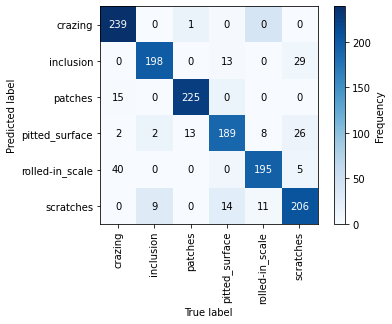

In [ ]:
from torchvision.transforms.functional import rotate
y_pred_train = []
y_true_train = []

with torch.no_grad():
    for x, y in dataloader_train:
        outputs = model(x)
        _, label = torch.max(outputs.data, 1)
        y_pred_train += label.detach().numpy().tolist()
        y_true_train += y.detach().numpy().tolist()

y_pred_t = np.array(y_pred_train)
y_true_t = np.array(y_true_train)

classes = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

confusion = np.zeros([6, 6], dtype=int)
for i in range(len(y_pred_t)):
    row_idx = y_pred_t[i].round()
    col_idx = y_true_t[i].round()
    confusion[row_idx.astype(int), col_idx.astype(int)] += 1

fig, ax = plt.subplots()
im = ax.imshow(confusion, 'Blues')
cb = plt.colorbar(im)
cb.set_label('Frequency')
_ = ax.set_xticks(np.arange(len(classes)))
_ = ax.set_yticks(np.arange(len(classes)))
_ = ax.set_xticklabels(classes, rotation=90)
_ = ax.set_yticklabels(classes)
_ = ax.set_xlabel('True label')
_ = ax.set_ylabel('Predicted label')

for i in range(len(classes)):
    for j in range(len(classes)):
        if confusion[i, j] > 100:
            tc = 'w'
        else:
            tc = 'k'
        ax.text(i, j, confusion[i, j], ha='center', va="center", color=tc)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(dataloader_val), total=len(dataloader_val))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nVal Accuracy: {accuracy:.2f}%')


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


Val Accuracy: 74.72%


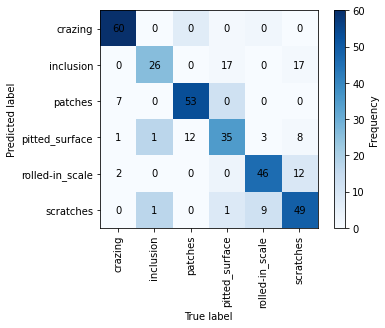

In [ ]:
y_pred_val = []
y_true_val = []

with torch.no_grad():
    for x, y in dataloader_val:
        outputs = model(x)
        _, label = torch.max(outputs.data, 1)
        y_pred_val += label.detach().numpy().tolist()
        y_true_val += y.detach().numpy().tolist()

y_pred_v = np.array(y_pred_val)
y_true_v = np.array(y_true_val)

confusion = np.zeros([6, 6], dtype=int)
for i in range(len(y_pred_v)):
    row_idx = y_pred_v[i].round()
    col_idx = y_true_v[i].round()
    confusion[row_idx.astype(int), col_idx.astype(int)] += 1

fig, ax = plt.subplots()
im = ax.imshow(confusion, 'Blues')
cb = plt.colorbar(im)
cb.set_label('Frequency')
_ = ax.set_xticks(np.arange(len(classes)))
_ = ax.set_yticks(np.arange(len(classes)))
_ = ax.set_xticklabels(classes, rotation=90)
_ = ax.set_yticklabels(classes)
_ = ax.set_xlabel('True label')
_ = ax.set_ylabel('Predicted label')

for i in range(6):
    for j in range(6):
        if confusion[i, j] > 100:
            tc = 'w'
        else:
            tc = 'k'
        ax.text(i, j, confusion[i, j], ha='center', va="center", color=tc)

Problem 2.d & 2.e

In the case of the confusion matrix for the training set, the overall accuracy is 86.94%. It seems to perform best on crazing, inclusion and patches, and the most poorly on scratches. Pitted_surface and scratches have a high number of both false positives and false negatives, while inclusion has a relatively low number of false positives, but a high number of false negatives.
The overall accuracy on the validation set is 74.72%, slightly lower in comparison to the test one. The same pattern as the train confusion matrix can be seen in the validation one; however, pitted_surface has a lower number of false positives.
Overall, the model seems to be struggling to correctly classify scratches.

Scratches and inclusion seem to be most wrongly classified as the other. The reason why this may be the case, looking for instance at "scratch image 1" and "inclusion image 1" is that there appears to be a straight line on both, so they seem to be similar in nature as a defect.  

# Problem 3: hyperparameter tuning

(a) Split the validation set into separate validation / test `Datasets` using the `torch.utils.data.Subset` class.

(b) Set up the hyperparameter tuning problem using `ax-platform`.
> Note: CNN training takes a long time so you won't be able to perform very many iterations! This is why I specify to use Bayesian optimization with GP regression (it's more efficient).

> You may want to enable the GPU by going to `Edit` ➡ `Notebook settings` ➡ `Hardware accelerator` ➡ `GPU`.

(c) Tune the CNN hyperparameters to minimize validation Cross Entropy Loss.

(d) Report the accuracy of the tuned model on train, validation, and test sets.

(e) Comment on the tuned architecture compared to the one you used in Problem 2.
What change had the greatest effect?

In [7]:
#Problem 3.a
from torch.utils.data import Subset

val_size = int(0.8 * len(dataset_val))
test_size = len(dataset_val) - val_size

val_indices = list(range(val_size))
test_indices = list(range(val_size, len(dataset_val)))

val_subset = Subset(dataset_val, val_indices)
test_subset = Subset(dataset_val, test_indices)

val_loader = DataLoader(val_subset, batch_size=25, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=25, shuffle=True)

In [ ]:
!pip install ax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install ax-platform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 49.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.8/245.8 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.3 MB/s eta 0:00:00


In [9]:
!pip install ax --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.2/227.2 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.0/265.0 KB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 66.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250

In [ ]:
#Problem 3.b
import ax
from ax.service.managed_loop import optimize
from ax.utils.tutorials.cnn_utils import train, evaluate
from ax import RangeParameter, ParameterType

def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)

  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        eps=parameters.get("momentum", 1e-08)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0), 
  )

  num_epochs = parameters.get("num_epochs", 5)
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

In [ ]:
#Problem 3.c
def train_evaluate(parameterization):

    train_loader = dataloader_train
    untrained_net = ClassifierCNN(conv_channels=[16, 32], fc_dim=64, num_classes=6) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [ ]:
dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [0.005, 0.05], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [12, 20]},
        {"name": "eps", "type": "range", "bounds": [0.005, 0.05]},
        {"name": "max_epoch", "type": "range", "bounds": [3, 18]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},        
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
    minimize=True,
    total_trials=2
)

print(best_parameters)

[INFO 02-27 21:47:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-27 21:47:37] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-27 21:47:37] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter eps. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-27 21:47:37] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter max_epoch. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[

{'lr': 0.011258715139931345, 'batchsize': 20, 'eps': 0.018682860136032105, 'max_epoch': 15}


In [17]:
class ClassifierCNN_opt(pl.LightningModule):
    def __init__(self, conv_channels, fc_dim, num_classes):
        super(ClassifierCNN_opt, self).__init__()
        
        conv_blocks = []
        for i, c in enumerate(conv_channels):
            conv_blocks.append( ConvBlock(c) )

        self.conv = nn.Sequential(*conv_blocks)
        self.fc = nn.Sequential(nn.LazyLinear(fc_dim),
                                nn.LeakyReLU(),
                                nn.LazyLinear(num_classes))

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1) 
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.011258715139931345, eps=0.018682860136032105)
        return optimizer

In [19]:
#Problem 3.d
from pytorch_lightning.loggers import CSVLogger

train_loader_opt = DataLoader(dataset_train, batch_size=20, shuffle=True)
val_loader_opt = DataLoader(val_subset, batch_size=20, shuffle=True)
test_loader_opt = DataLoader(test_subset, batch_size=20, shuffle=True)

model_opt = ClassifierCNN_opt(conv_channels=[16, 32], fc_dim=64, num_classes=6)
model_opt(dataloader_train.dataset[0][0].unsqueeze(0))

logger = CSVLogger("logs")

trainer = pl.Trainer(max_epochs=15, logger=logger, log_every_n_steps=len(train_loader_opt))
trainer.fit(model=model_opt, train_dataloaders=train_loader_opt, val_dataloaders=val_loader_opt)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | conv      | Sequential       | 5.1 K 
1 | fc        | Sequential       | 5.1 M 
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.1 M     Trainable params
0         Non-trainable params
5.1 M     Total params
20.502    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


In [ ]:
#Problem 3.d
with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(train_loader_opt), total=len(train_loader_opt))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = model_opt(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nTrain Accuracy: {accuracy:.2f}%')

with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(val_loader_opt), total=len(val_loader_opt))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = model_opt(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nVal Accuracy: {accuracy:.2f}%')

with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(test_loader_opt), total=len(test_loader_opt))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = model_opt(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')

100%|██████████| 72/72 [00:21<00:00,  3.39it/s]



Train Accuracy: 89.86%


100%|██████████| 15/15 [00:04<00:00,  3.05it/s]



Val Accuracy: 61.11%


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


Test Accuracy: 58.33%


Problem 3.e

The optimizer is the main thing that was altered between the two models. The learning rate was tuned and the epsilon for numerical stability was added. However, despite the accuracy on train improved noticeably, the validation accuracy decreased compared to the model in the previous problem.

# Problem 4: transfer learning

(a) Load a pretrained model from [`torchvision`](https://pytorch.org/vision/stable/models.html) or [micro-net](`https://github.com/nasa/pretrained-microscopy-models`).

(b) Compute the features of all your images using the pretrained model.

(c) Train a shallow MLP to perform the classification task based on the image features from Part b.

(d) Report the training and validation accuracy.
Create a confusion matrix on the validation set.

(e) Comment on the differences in training time between the transfer learning and CNN models from Problems 2-3.
Comment on the differences in performance between this model and those in Problems 2-3.

In [ ]:
#Problem 4.a
import torch
import torchvision.models as models

modelP = models.resnet18(pretrained=True)
modelP.eval()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Problem 4.b
train_features = []
train_labels = []

with torch.no_grad():
    prog = tqdm.tqdm(dataloader_train, total=len(dataloader_train))
    for x, y in prog:
        out = modelP(x)
        train_features.append(out.detach().numpy())
        train_labels.append(y.detach().numpy())

train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels)

print(train_features.shape)

100%|██████████| 58/58 [01:20<00:00,  1.38s/it]

(1440, 1000)


In [ ]:
#Problem 4.c

class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()

        self.pretrained = models.resnet18(pretrained=True)
        self.classifier = nn.LazyLinear(num_classes)

        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.criterion(out, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
torch.manual_seed(0)
num_classes = len(dataset_train.classes)
modelMLP = ResNetClassifier(num_classes)

modelMLP(dataloader_train.dataset[0][0].unsqueeze(0))

dataloader_train_shuffle = DataLoader(dataset_train, batch_size=16, shuffle=True)

trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=modelMLP, train_dataloaders=dataloader_train_shuffle)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.uti

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
#Problem 4.d
with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(dataloader_train_shuffle), total=len(dataloader_train_shuffle))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = modelMLP(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nTrain Accuracy MLP: {accuracy:.2f}%')


100%|██████████| 90/90 [01:25<00:00,  1.05it/s]


Train Accuracy MLP: 67.85%


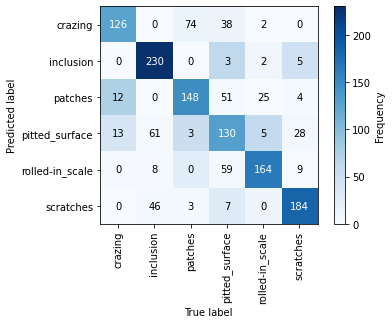

In [ ]:
y_pred_train_MLP = []
y_true_train_MLP = []

with torch.no_grad():
    for x, y in dataloader_train_shuffle:
        outputs = modelMLP(x)
        _, label = torch.max(outputs.data, 1)
        y_pred_train_MLP += label.detach().numpy().tolist()
        y_true_train_MLP += y.detach().numpy().tolist()

y_pred_t_MLP = np.array(y_pred_train_MLP)
y_true_t_MLP = np.array(y_true_train_MLP)

classes = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

confusion = np.zeros([6, 6], dtype=int)
for i in range(len(y_pred_t_MLP)):
    row_idx = y_pred_t_MLP[i].round()
    col_idx = y_true_t_MLP[i].round()
    confusion[row_idx.astype(int), col_idx.astype(int)] += 1

fig, ax = plt.subplots()
im = ax.imshow(confusion, 'Blues')
cb = plt.colorbar(im)
cb.set_label('Frequency')
_ = ax.set_xticks(np.arange(len(classes)))
_ = ax.set_yticks(np.arange(len(classes)))
_ = ax.set_xticklabels(classes, rotation=90)
_ = ax.set_yticklabels(classes)
_ = ax.set_xlabel('True label')
_ = ax.set_ylabel('Predicted label')

for i in range(len(classes)):
    for j in range(len(classes)):
        if confusion[i, j] > 100:
            tc = 'w'
        else:
            tc = 'k'
        ax.text(i, j, confusion[i, j], ha='center', va="center", color=tc)

In [ ]:
dataloader_val_shuffle = DataLoader(dataset_val, batch_size=16, shuffle=True)

with torch.no_grad():
    correct = 0
    total = 0
    pbar = tqdm.tqdm(enumerate(dataloader_val_shuffle), total=len(dataloader_val_shuffle))
    for i, (images, labels) in pbar:

        # Forward pass
        outputs = modelMLP(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Compute accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'\nVal Accuracy: {accuracy:.2f}%')

100%|██████████| 23/23 [00:21<00:00,  1.07it/s]


Val Accuracy: 35.28%


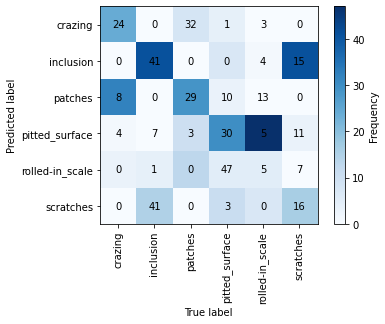

In [ ]:
y_pred_val_MLP = []
y_true_val_MLP = []

with torch.no_grad():
    for x, y in dataloader_val_shuffle:
        outputs = modelMLP(x)
        _, label = torch.max(outputs.data, 1)
        y_pred_val_MLP += label.detach().numpy().tolist()
        y_true_val_MLP += y.detach().numpy().tolist()

y_pred_v_MLP = np.array(y_pred_val_MLP)
y_true_v_MLP = np.array(y_true_val_MLP)

confusion = np.zeros([6, 6], dtype=int)
for i in range(len(y_pred_v_MLP)):
    row_idx = y_pred_v_MLP[i].round()
    col_idx = y_true_v_MLP[i].round()
    confusion[row_idx.astype(int), col_idx.astype(int)] += 1

fig, ax = plt.subplots()
im = ax.imshow(confusion, 'Blues')
cb = plt.colorbar(im)
cb.set_label('Frequency')
_ = ax.set_xticks(np.arange(len(classes)))
_ = ax.set_yticks(np.arange(len(classes)))
_ = ax.set_xticklabels(classes, rotation=90)
_ = ax.set_yticklabels(classes)
_ = ax.set_xlabel('True label')
_ = ax.set_ylabel('Predicted label')

for i in range(6):
    for j in range(6):
        if confusion[i, j] > 100:
            tc = 'w'
        else:
            tc = 'k'
        ax.text(i, j, confusion[i, j], ha='center', va="center", color=tc)

Problem 4.e

The training time for this shallow MLP has definitely been lower than the CNN model in problem 3, and has had a similar training time to problem 2. However, the accuracy of this shallow MLP is quite different from the previous models.
Both train and validation accuracy are worse for this shallow MLP than the previous models used. This is highlighted by the confusion matrices as well. Reasons for this could be the lack of hyperparameter tuning (crucial for shallow MLPs), or dataset complexity since CNN can extract features that are robust to variations that may be present in image datasets. 